# Train classification model with standard AE features

In [2]:
from urllib.request import urlretrieve
import pandas as pd
import vallenae
import seaborn as sns
import sklearn

## Download pmma-plate-sources dataset

In [3]:
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/plb.pridb", filename="plb.pridb")
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/salt.pridb", filename="salt.pridb")
urlretrieve("https://filetransfer.vallen.de/openae/datasets/pmma-plate-sources/pulse.pridb", filename="pulse.pridb")

('pulse.pridb', <http.client.HTTPMessage at 0x274e9c2f910>)

## Read AE features from pridb files

In [4]:
%%time
def read_features_from_file(filepath) -> pd.DataFrame:
    with vallenae.io.PriDatabase(filepath) as pridb:
        return pd.DataFrame(
            {
                "amplitude": hit.amplitude,
                "energy":    hit.energy,
                "duration":  hit.duration,
                "risetime":  hit.rise_time,
                "counts":    hit.counts,
            }
            for hit in pridb.iread_hits()
        )

df = pd.concat(
    [
        read_features_from_file("plb.pridb").assign(label="plb"),
        read_features_from_file("salt.pridb").assign(label="salt"),
        read_features_from_file("pulse.pridb").assign(label="pulse"),
    ],
    ignore_index=True,
).astype({"label": "category"})

df

CPU times: total: 15.6 ms
Wall time: 10.5 ms


,amplitude,energy,duration,risetime,counts,label
0,0.027812,2.108759e+06,0.001311,0.000057,148,plb
1,0.034504,2.414063e+06,0.001194,0.000057,150,plb
2,0.029771,2.409281e+06,0.001114,0.000089,141,plb
3,0.039014,3.825626e+06,0.001878,0.000052,192,plb
4,0.039066,3.473499e+06,0.001321,0.000055,144,plb
...,...,...,...,...,...,...
835,0.039512,9.660091e+06,0.001823,0.000138,248,pulse
836,0.027037,3.175820e+06,0.001580,0.000098,209,pulse
837,0.044374,9.567427e+06,0.002236,0.000058,249,pulse
838,0.039529,9.665963e+06,0.001823,0.000138,246,pulse


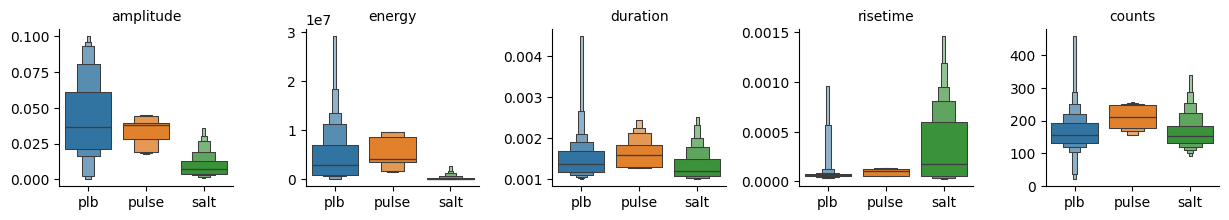

In [5]:
sns.catplot(
    df.melt(id_vars="label", var_name="feature", value_name="value"),
    x="label",
    y="value",
    hue="label",
    col="feature",
    col_wrap=5,
    height=2.5,
    kind="boxen",
    sharey=False,
    showfliers=False,
).set_titles("{col_name}").set(xlabel=None, ylabel=None)

## Train/test split

In [6]:
X = df.drop(columns="label").to_numpy()
y = df["label"].cat.codes.to_numpy()

feature_names = df.drop(columns="label").columns
label_names = df["label"].cat.categories

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=11)

## Train model

In [7]:
scaler = sklearn.preprocessing.StandardScaler()
clf = sklearn.svm.LinearSVC()
pipeline = sklearn.pipeline.make_pipeline(scaler, clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

## Scores & confusion matrix

Accuracy: 0.7714285714285715
              precision    recall  f1-score   support

         plb       0.71      0.74      0.73        66
       pulse       0.88      0.63      0.74        71
        salt       0.76      0.93      0.83        73

    accuracy                           0.77       210
   macro avg       0.78      0.77      0.77       210
weighted avg       0.78      0.77      0.77       210



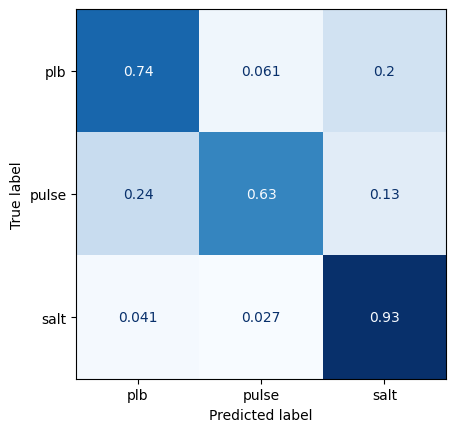

In [8]:
y_test_pred = pipeline.predict(X_test)
print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_test_pred))
print(sklearn.metrics.classification_report(y_test, y_test_pred, target_names=label_names))

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred, normalize="true")
sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(cmap="Blues", colorbar=False)